In [1]:
!pip install flopco-pytorch

!gdown --id 1zFqrlK2WDPzZw5EyrjdOB-UWt5xOj-iS
!tar -xf arxiv.tar
!ls

Downloading...
From: https://drive.google.com/uc?id=1zFqrlK2WDPzZw5EyrjdOB-UWt5xOj-iS
To: /content/arxiv.tar
100% 45.0M/45.0M [00:00<00:00, 87.0MB/s]
arxiv.tar		 pruning_utils.py  sample_data
cifar100-resnet18_8x.pt  resnet_8x.py	   utils.py


[Link](https://drive.google.com/file/d/1zFqrlK2WDPzZw5EyrjdOB-UWt5xOj-iS/view?usp=sharing) to arxiv.tar where utils and pruning_utils Python modules can be found.

In [2]:
import torch
import torch.nn as nn
from resnet_8x import ResNet18_8x, BasicBlock

import numpy as np

from copy import deepcopy

import pruning_utils as putils

from time import time

import matplotlib.pyplot as plt
%matplotlib inline

## Task 1. Analytical Computation of MAC Reduction [2 points]

Consider a convolutional layer with convolutional kernel of the shape $(C_{out}, C_{in}, k_{h}, k_{w})$, where:
$$k_h = k_w = 5, C_{in} = 3, C_{out} = 16$$

Assume we prune 25% of filters in convolutional layer to obtain a compressed convolutional layer.

Let input image be of size $(C_{in}, H_{in}, W_{in})$, where $H_{in} = W_{in} = 32$

1) Compute number of MAC in the initial convolutional layer, MAC_initial

2) Compute number of MAC in the compressed convolutional layer, MAC_compressed

3) Compute MAC reduction rate as (1 - MAC_compressed / MAC_initial)

$H_{out} = W_{out} = H_{in} - k_{in}+1 = 32 - 5 + 1$

$ =28$

Fortunately, we already know derivated formula for standard convolutional layer:

**MAC** $= C_{in} \cdot C_{out} \cdot W_{out} \cdot H_{out}  \cdot k_{in} \cdot k_{out}$

**1)**

$\text{MAC}_{initial} = 3 \cdot 16 \cdot 28^2 \cdot 5^2 = 940800$

**2)**

Now, $C_{out} = 16 \cdot (1 - {1 \over 4}) = 12$

$\text{MAC}_{compressed} = 3 \cdot 12 \cdot 28^2 \cdot 5^2 = 705600$ 

**3)**

$\text{MAC RR} = (1 - {\text{MAC}_{compressed} \over \text{MAC}_{initial}}) = 1 - 0.75 = 0.25$

## Task 2. Global Threshold for  Unstructed Pruning [1 point]

In this task for unstructed pruning you will prune neural network by removing all weights of convolutional layers that are smaller than some threshold.

In seminar we implemented local pruning strategy: removed some portion of weight elements for each layer separately.

Now, you need to implement global pruning strategy, namely you need to find global threshold(one value for all neural network convolutional weights) that corresponds to x% pruning rate (ratio of weight elements that we prune or set to zero).

In [3]:
from utils import get_layer_by_name

def get_global_threshold(model, conv_list, prune_rate):
    """
    model: nn.Module
        neural network to be pruned
    conv_list: list(str)
        list of names of convolutional layers to be pruned
    prune_rate: float
        Value in range (0, 1) that corresponds to the ratio of pruned weight elements from all convolutional layers from `conv_list`.

    Return:
        threshold: float
            If we remove all convolutional weights elements less than `threshold` then we get pruning rate equaled `prune_rate`.
    """


    weights = [] # list to store weights of convolutional layers

    for conv_name in conv_list:        
        conv = get_layer_by_name(model, conv_name)
        weights += conv.weight.data.abs().reshape(1, -1)

    weights = torch.cat(weights)

    # hint: use torch.quantile to find threshold
    threshold = torch.quantile(weights, prune_rate, dim=None)
    print(f"Global threshold: {threshold.item():.3e}")

    return threshold

In [4]:
model = ResNet18_8x(num_classes=100)
model.load_state_dict(torch.load("cifar100-resnet18_8x.pt"))

conv_layers = [module_name for module_name, module in model.named_modules() if isinstance(module, nn.Conv2d)]

In [5]:
get_global_threshold(model, conv_layers, prune_rate=0.3)

Global threshold: 2.056e-03


tensor(0.0021)

## Preparation for the following tasks 

In [6]:
from utils import batchnorm_callibration, get_validation_scores, fix_random_seed, get_cifar100_dataloader

fix_random_seed(seed=42)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
dataset_path = './'
batch_size = 256
num_workers = 0

train_loader, val_loader = get_cifar100_dataloader(dataset_path, batch_size, num_workers, download=True)
calibrate_batches = 200

  0%|          | 0/169001437 [00:00<?, ?it/s]

Extracting ./cifar-100-python.tar.gz to ./
Files already downloaded and verified


## Task 3. Accuracy-Pruning rate Trade-off for Local Unstructed Pruning [1 points]

In this task you will investigate what happens with neural network accuracy if you prune only one Basic block from ResNet architecture.

And you will analyze how sensitive is the network accuracy to pruning of different Basic blocks.

Namely, you should do the following for each Basic block:

- Take an initial model

- For pruning rate from the list of considered pruning rates:
    - Given pruning rate prune considered Basic block (You'll get a model, where one Basic block is compressed)
    - Compute accuracies for compressed model

After all computations you will get a dictionary `dict_unstructed`, where keys stands for Basic block names and `dict_unstructed[key]` is a tuple `(accs, ratios)`, where `accs` are accuracies corresponding for pruning rates `ratios`.



In [7]:
evaluated_basicblocks = [
    'layer1.0',
    'layer1.1',
    'layer2.0',
    'layer2.1',
    'layer3.0',
    'layer3.1',
    'layer4.0',
    'layer4.1'
]
strategy = "local"
prune_rates = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

dict_unstructed = {}

try:
    dict_unstructed = np.load("results.npy").item()
except:
    pass

for bname in evaluated_basicblocks:

    if bname in dict_unstructed:
        print(f'Accuracies for BasicBlock {bname} have been already computed')
        continue
        
    print(f'\n\nStart computation for BasicBlock {bname}...')
    accs, prune_ratios = [], []
    for prune_rate in prune_rates:
        
        conv_list_local = [f'{bname}.conv1', f'{bname}.conv2']
        model_pruned = putils.prune_unstructed(model, conv_list_local, prune_rate=prune_rate)
        nonzero_ratio, _ = putils.compute_nonzero_ratio(model_pruned, conv_list_local)
        model_pruned = model_pruned.to(device)
        
        top1_acc, _ = get_validation_scores(model_pruned, val_loader, device=device)
        print(f'\tAccuracies for pruning rate {prune_rate} have been computed')
        accs += [top1_acc]
        prune_ratios += [1 - nonzero_ratio] 

    dict_unstructed[bname] = [np.array(accs), np.array(prune_ratios)]
    np.save("results.npy", dict_unstructed)



Start computation for BasicBlock layer1.0...


  0%|          | 0/40 [00:00<?, ?it/s]

	Accuracies for pruning rate 0.1 have been computed


  0%|          | 0/40 [00:00<?, ?it/s]

	Accuracies for pruning rate 0.2 have been computed


  0%|          | 0/40 [00:00<?, ?it/s]

	Accuracies for pruning rate 0.3 have been computed


  0%|          | 0/40 [00:00<?, ?it/s]

	Accuracies for pruning rate 0.4 have been computed


  0%|          | 0/40 [00:00<?, ?it/s]

	Accuracies for pruning rate 0.5 have been computed


  0%|          | 0/40 [00:00<?, ?it/s]

	Accuracies for pruning rate 0.6 have been computed


  0%|          | 0/40 [00:00<?, ?it/s]

	Accuracies for pruning rate 0.7 have been computed


  0%|          | 0/40 [00:00<?, ?it/s]

	Accuracies for pruning rate 0.8 have been computed


  0%|          | 0/40 [00:00<?, ?it/s]

	Accuracies for pruning rate 0.9 have been computed


Start computation for BasicBlock layer1.1...


  0%|          | 0/40 [00:00<?, ?it/s]

	Accuracies for pruning rate 0.1 have been computed


  0%|          | 0/40 [00:00<?, ?it/s]

	Accuracies for pruning rate 0.2 have been computed


  0%|          | 0/40 [00:00<?, ?it/s]

	Accuracies for pruning rate 0.3 have been computed


  0%|          | 0/40 [00:00<?, ?it/s]

	Accuracies for pruning rate 0.4 have been computed


  0%|          | 0/40 [00:00<?, ?it/s]

	Accuracies for pruning rate 0.5 have been computed


  0%|          | 0/40 [00:00<?, ?it/s]

	Accuracies for pruning rate 0.6 have been computed


  0%|          | 0/40 [00:00<?, ?it/s]

	Accuracies for pruning rate 0.7 have been computed


  0%|          | 0/40 [00:00<?, ?it/s]

	Accuracies for pruning rate 0.8 have been computed


  0%|          | 0/40 [00:00<?, ?it/s]

	Accuracies for pruning rate 0.9 have been computed


Start computation for BasicBlock layer2.0...


  0%|          | 0/40 [00:00<?, ?it/s]

	Accuracies for pruning rate 0.1 have been computed


  0%|          | 0/40 [00:00<?, ?it/s]

	Accuracies for pruning rate 0.2 have been computed


  0%|          | 0/40 [00:00<?, ?it/s]

	Accuracies for pruning rate 0.3 have been computed


  0%|          | 0/40 [00:00<?, ?it/s]

	Accuracies for pruning rate 0.4 have been computed


  0%|          | 0/40 [00:00<?, ?it/s]

	Accuracies for pruning rate 0.5 have been computed


  0%|          | 0/40 [00:00<?, ?it/s]

	Accuracies for pruning rate 0.6 have been computed


  0%|          | 0/40 [00:00<?, ?it/s]

	Accuracies for pruning rate 0.7 have been computed


  0%|          | 0/40 [00:00<?, ?it/s]

	Accuracies for pruning rate 0.8 have been computed


  0%|          | 0/40 [00:00<?, ?it/s]

	Accuracies for pruning rate 0.9 have been computed


Start computation for BasicBlock layer2.1...


  0%|          | 0/40 [00:00<?, ?it/s]

	Accuracies for pruning rate 0.1 have been computed


  0%|          | 0/40 [00:00<?, ?it/s]

	Accuracies for pruning rate 0.2 have been computed


  0%|          | 0/40 [00:00<?, ?it/s]

	Accuracies for pruning rate 0.3 have been computed


  0%|          | 0/40 [00:00<?, ?it/s]

	Accuracies for pruning rate 0.4 have been computed


  0%|          | 0/40 [00:00<?, ?it/s]

	Accuracies for pruning rate 0.5 have been computed


  0%|          | 0/40 [00:00<?, ?it/s]

	Accuracies for pruning rate 0.6 have been computed


  0%|          | 0/40 [00:00<?, ?it/s]

	Accuracies for pruning rate 0.7 have been computed


  0%|          | 0/40 [00:00<?, ?it/s]

	Accuracies for pruning rate 0.8 have been computed


  0%|          | 0/40 [00:00<?, ?it/s]

	Accuracies for pruning rate 0.9 have been computed


Start computation for BasicBlock layer3.0...


  0%|          | 0/40 [00:00<?, ?it/s]

	Accuracies for pruning rate 0.1 have been computed


  0%|          | 0/40 [00:00<?, ?it/s]

	Accuracies for pruning rate 0.2 have been computed


  0%|          | 0/40 [00:00<?, ?it/s]

	Accuracies for pruning rate 0.3 have been computed


  0%|          | 0/40 [00:00<?, ?it/s]

	Accuracies for pruning rate 0.4 have been computed


  0%|          | 0/40 [00:00<?, ?it/s]

	Accuracies for pruning rate 0.5 have been computed


  0%|          | 0/40 [00:00<?, ?it/s]

	Accuracies for pruning rate 0.6 have been computed


  0%|          | 0/40 [00:00<?, ?it/s]

	Accuracies for pruning rate 0.7 have been computed


  0%|          | 0/40 [00:00<?, ?it/s]

	Accuracies for pruning rate 0.8 have been computed


  0%|          | 0/40 [00:00<?, ?it/s]

	Accuracies for pruning rate 0.9 have been computed


Start computation for BasicBlock layer3.1...


  0%|          | 0/40 [00:00<?, ?it/s]

	Accuracies for pruning rate 0.1 have been computed


  0%|          | 0/40 [00:00<?, ?it/s]

	Accuracies for pruning rate 0.2 have been computed


  0%|          | 0/40 [00:00<?, ?it/s]

	Accuracies for pruning rate 0.3 have been computed


  0%|          | 0/40 [00:00<?, ?it/s]

	Accuracies for pruning rate 0.4 have been computed


  0%|          | 0/40 [00:00<?, ?it/s]

	Accuracies for pruning rate 0.5 have been computed


  0%|          | 0/40 [00:00<?, ?it/s]

	Accuracies for pruning rate 0.6 have been computed


  0%|          | 0/40 [00:00<?, ?it/s]

	Accuracies for pruning rate 0.7 have been computed


  0%|          | 0/40 [00:00<?, ?it/s]

	Accuracies for pruning rate 0.8 have been computed


  0%|          | 0/40 [00:00<?, ?it/s]

	Accuracies for pruning rate 0.9 have been computed


Start computation for BasicBlock layer4.0...


  0%|          | 0/40 [00:00<?, ?it/s]

	Accuracies for pruning rate 0.1 have been computed


  0%|          | 0/40 [00:00<?, ?it/s]

	Accuracies for pruning rate 0.2 have been computed


  0%|          | 0/40 [00:00<?, ?it/s]

	Accuracies for pruning rate 0.3 have been computed


  0%|          | 0/40 [00:00<?, ?it/s]

	Accuracies for pruning rate 0.4 have been computed


  0%|          | 0/40 [00:00<?, ?it/s]

	Accuracies for pruning rate 0.5 have been computed


  0%|          | 0/40 [00:00<?, ?it/s]

	Accuracies for pruning rate 0.6 have been computed


  0%|          | 0/40 [00:00<?, ?it/s]

	Accuracies for pruning rate 0.7 have been computed


  0%|          | 0/40 [00:00<?, ?it/s]

	Accuracies for pruning rate 0.8 have been computed


  0%|          | 0/40 [00:00<?, ?it/s]

	Accuracies for pruning rate 0.9 have been computed


Start computation for BasicBlock layer4.1...


  0%|          | 0/40 [00:00<?, ?it/s]

	Accuracies for pruning rate 0.1 have been computed


  0%|          | 0/40 [00:00<?, ?it/s]

	Accuracies for pruning rate 0.2 have been computed


  0%|          | 0/40 [00:00<?, ?it/s]

	Accuracies for pruning rate 0.3 have been computed


  0%|          | 0/40 [00:00<?, ?it/s]

	Accuracies for pruning rate 0.4 have been computed


  0%|          | 0/40 [00:00<?, ?it/s]

	Accuracies for pruning rate 0.5 have been computed


  0%|          | 0/40 [00:00<?, ?it/s]

	Accuracies for pruning rate 0.6 have been computed


  0%|          | 0/40 [00:00<?, ?it/s]

	Accuracies for pruning rate 0.7 have been computed


  0%|          | 0/40 [00:00<?, ?it/s]

	Accuracies for pruning rate 0.8 have been computed


  0%|          | 0/40 [00:00<?, ?it/s]

	Accuracies for pruning rate 0.9 have been computed


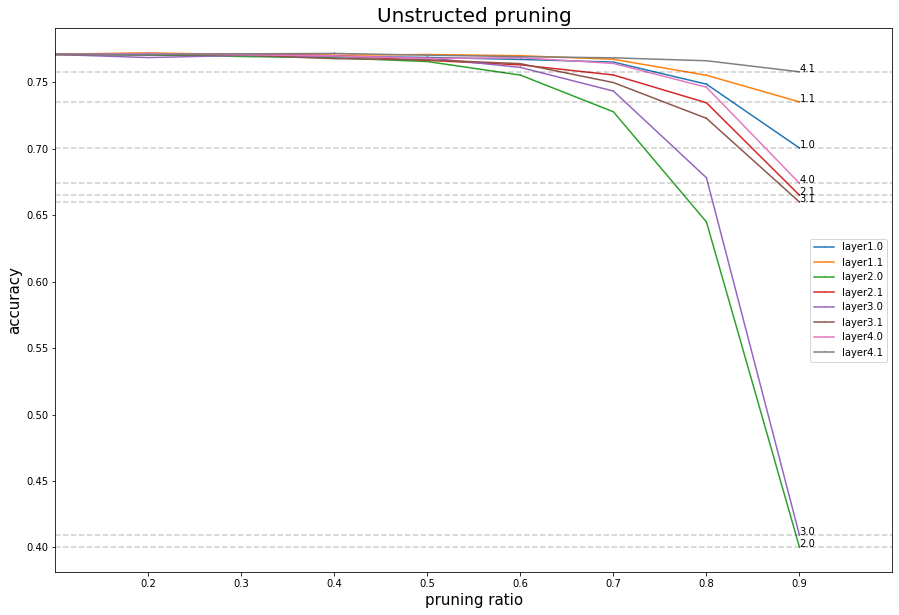

In [8]:
plt.figure(figsize=(15, 10))

for i, key in enumerate(dict_unstructed.keys()):
    accs = dict_unstructed[key][0]
    ratios = dict_unstructed[key][1]
    plt.plot(ratios, accs, ',-', label=key)
    plt.text(ratios[-1], accs[-1], key[-3:])
    plt.axhline(accs[-1], linestyle='--', c='k', alpha=0.2)

plt.xlim(ratios[0], ratios[-1]+0.1)
plt.xlabel('pruning ratio', fontsize=15)
plt.ylabel('accuracy', fontsize=15)
plt.title('Unstructed pruning', fontsize=20)
plt.legend()

plt.show()

**Corollary:**

1. Well, from plot above we could say, that every #.1 layer is less sensitive, than its neighbour #.0

    I analysed model structure and it looks like senstiveness could depend on input matrix passed to convolution layer(#.1 shape always >= #.0 shape). 
2. Its not clear how sensetiveness depends of layer depends on changing ratio, so let's say it does not.
3. Until $\sim$0.5 pruning ratio all layers perform with approximately similar accuracy

## Task 4. Accuracy-Pruning rate Trade-off for Local Structed Pruning  [1 point]

Perform the same computations as in Task 3, but for structed pruning. To select channels estimate L1 norm of output channels of 1st convolution in Basic block (discussed at seminar).

That is for each Basic block for pruning rate from the list of considered pruning rates:

    - Given pruning rate prune considered Basic block (You'll get a model, where one Basic block is compressed)
    - Compute accuracies for compressed model

In [9]:
evaluated_basicblocks = [
    'layer1.0',
    'layer1.1',
    'layer2.0',
    'layer2.1',
    'layer3.0',
    'layer3.1',
    'layer4.0',
    'layer4.1'
]
strategy = "local"
prune_rates = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

dict_structed = {}

try:
    dict_structed = np.load("results_structed.npy").item()
except:
    pass

for bname in evaluated_basicblocks:

    if bname in dict_structed:
        print(f'Accuracies for BasicBlock {bname} have been already computed')
        continue
        
    print(f'\n\nStart computation for BasicBlock {bname}...')
    accs, ratios = [], []
    for prune_rate in prune_rates:
        
        conv_list_local = [bname]
        model_pruned = putils.prune_structed(model, conv_list_local, prune_rate, 'l1')
        model_pruned = model_pruned.to(device)
        
        top1_acc, _ = get_validation_scores(model_pruned, val_loader, device=device)
        print(f'\tAccuracies for pruning rate {prune_rate} have been computed')
        accs += [top1_acc]
        ratios += [prune_rate] 

    dict_structed[bname] = [np.array(accs), np.array(ratios)]
    np.save("results_structed.npy", dict_structed)



Start computation for BasicBlock layer1.0...


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/conv.py:132: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  (out_channels, in_channels // groups, *kernel_size), **factory_kwargs))


  0%|          | 0/40 [00:00<?, ?it/s]

	Accuracies for pruning rate 0.1 have been computed


  0%|          | 0/40 [00:00<?, ?it/s]

	Accuracies for pruning rate 0.2 have been computed


  0%|          | 0/40 [00:00<?, ?it/s]

	Accuracies for pruning rate 0.3 have been computed


  0%|          | 0/40 [00:00<?, ?it/s]

	Accuracies for pruning rate 0.4 have been computed


  0%|          | 0/40 [00:00<?, ?it/s]

	Accuracies for pruning rate 0.5 have been computed


  0%|          | 0/40 [00:00<?, ?it/s]

	Accuracies for pruning rate 0.6 have been computed


  0%|          | 0/40 [00:00<?, ?it/s]

	Accuracies for pruning rate 0.7 have been computed


  0%|          | 0/40 [00:00<?, ?it/s]

	Accuracies for pruning rate 0.8 have been computed


  0%|          | 0/40 [00:00<?, ?it/s]

	Accuracies for pruning rate 0.9 have been computed


Start computation for BasicBlock layer1.1...


  0%|          | 0/40 [00:00<?, ?it/s]

	Accuracies for pruning rate 0.1 have been computed


  0%|          | 0/40 [00:00<?, ?it/s]

	Accuracies for pruning rate 0.2 have been computed


  0%|          | 0/40 [00:00<?, ?it/s]

	Accuracies for pruning rate 0.3 have been computed


  0%|          | 0/40 [00:00<?, ?it/s]

	Accuracies for pruning rate 0.4 have been computed


  0%|          | 0/40 [00:00<?, ?it/s]

	Accuracies for pruning rate 0.5 have been computed


  0%|          | 0/40 [00:00<?, ?it/s]

	Accuracies for pruning rate 0.6 have been computed


  0%|          | 0/40 [00:00<?, ?it/s]

	Accuracies for pruning rate 0.7 have been computed


  0%|          | 0/40 [00:00<?, ?it/s]

	Accuracies for pruning rate 0.8 have been computed


  0%|          | 0/40 [00:00<?, ?it/s]

	Accuracies for pruning rate 0.9 have been computed


Start computation for BasicBlock layer2.0...


  0%|          | 0/40 [00:00<?, ?it/s]

	Accuracies for pruning rate 0.1 have been computed


  0%|          | 0/40 [00:00<?, ?it/s]

	Accuracies for pruning rate 0.2 have been computed


  0%|          | 0/40 [00:00<?, ?it/s]

	Accuracies for pruning rate 0.3 have been computed


  0%|          | 0/40 [00:00<?, ?it/s]

	Accuracies for pruning rate 0.4 have been computed


  0%|          | 0/40 [00:00<?, ?it/s]

	Accuracies for pruning rate 0.5 have been computed


  0%|          | 0/40 [00:00<?, ?it/s]

	Accuracies for pruning rate 0.6 have been computed


  0%|          | 0/40 [00:00<?, ?it/s]

	Accuracies for pruning rate 0.7 have been computed


  0%|          | 0/40 [00:00<?, ?it/s]

	Accuracies for pruning rate 0.8 have been computed


  0%|          | 0/40 [00:00<?, ?it/s]

	Accuracies for pruning rate 0.9 have been computed


Start computation for BasicBlock layer2.1...


  0%|          | 0/40 [00:00<?, ?it/s]

	Accuracies for pruning rate 0.1 have been computed


  0%|          | 0/40 [00:00<?, ?it/s]

	Accuracies for pruning rate 0.2 have been computed


  0%|          | 0/40 [00:00<?, ?it/s]

	Accuracies for pruning rate 0.3 have been computed


  0%|          | 0/40 [00:00<?, ?it/s]

	Accuracies for pruning rate 0.4 have been computed


  0%|          | 0/40 [00:00<?, ?it/s]

	Accuracies for pruning rate 0.5 have been computed


  0%|          | 0/40 [00:00<?, ?it/s]

	Accuracies for pruning rate 0.6 have been computed


  0%|          | 0/40 [00:00<?, ?it/s]

	Accuracies for pruning rate 0.7 have been computed


  0%|          | 0/40 [00:00<?, ?it/s]

	Accuracies for pruning rate 0.8 have been computed


  0%|          | 0/40 [00:00<?, ?it/s]

	Accuracies for pruning rate 0.9 have been computed


Start computation for BasicBlock layer3.0...


  0%|          | 0/40 [00:00<?, ?it/s]

	Accuracies for pruning rate 0.1 have been computed


  0%|          | 0/40 [00:00<?, ?it/s]

	Accuracies for pruning rate 0.2 have been computed


  0%|          | 0/40 [00:00<?, ?it/s]

	Accuracies for pruning rate 0.3 have been computed


  0%|          | 0/40 [00:00<?, ?it/s]

	Accuracies for pruning rate 0.4 have been computed


  0%|          | 0/40 [00:00<?, ?it/s]

	Accuracies for pruning rate 0.5 have been computed


  0%|          | 0/40 [00:00<?, ?it/s]

	Accuracies for pruning rate 0.6 have been computed


  0%|          | 0/40 [00:00<?, ?it/s]

	Accuracies for pruning rate 0.7 have been computed


  0%|          | 0/40 [00:00<?, ?it/s]

	Accuracies for pruning rate 0.8 have been computed


  0%|          | 0/40 [00:00<?, ?it/s]

	Accuracies for pruning rate 0.9 have been computed


Start computation for BasicBlock layer3.1...


  0%|          | 0/40 [00:00<?, ?it/s]

	Accuracies for pruning rate 0.1 have been computed


  0%|          | 0/40 [00:00<?, ?it/s]

	Accuracies for pruning rate 0.2 have been computed


  0%|          | 0/40 [00:00<?, ?it/s]

	Accuracies for pruning rate 0.3 have been computed


  0%|          | 0/40 [00:00<?, ?it/s]

	Accuracies for pruning rate 0.4 have been computed


  0%|          | 0/40 [00:00<?, ?it/s]

	Accuracies for pruning rate 0.5 have been computed


  0%|          | 0/40 [00:00<?, ?it/s]

	Accuracies for pruning rate 0.6 have been computed


  0%|          | 0/40 [00:00<?, ?it/s]

	Accuracies for pruning rate 0.7 have been computed


  0%|          | 0/40 [00:00<?, ?it/s]

	Accuracies for pruning rate 0.8 have been computed


  0%|          | 0/40 [00:00<?, ?it/s]

	Accuracies for pruning rate 0.9 have been computed


Start computation for BasicBlock layer4.0...


  0%|          | 0/40 [00:00<?, ?it/s]

	Accuracies for pruning rate 0.1 have been computed


  0%|          | 0/40 [00:00<?, ?it/s]

	Accuracies for pruning rate 0.2 have been computed


  0%|          | 0/40 [00:00<?, ?it/s]

	Accuracies for pruning rate 0.3 have been computed


  0%|          | 0/40 [00:00<?, ?it/s]

	Accuracies for pruning rate 0.4 have been computed


  0%|          | 0/40 [00:00<?, ?it/s]

	Accuracies for pruning rate 0.5 have been computed


  0%|          | 0/40 [00:00<?, ?it/s]

	Accuracies for pruning rate 0.6 have been computed


  0%|          | 0/40 [00:00<?, ?it/s]

	Accuracies for pruning rate 0.7 have been computed


  0%|          | 0/40 [00:00<?, ?it/s]

	Accuracies for pruning rate 0.8 have been computed


  0%|          | 0/40 [00:00<?, ?it/s]

	Accuracies for pruning rate 0.9 have been computed


Start computation for BasicBlock layer4.1...


  0%|          | 0/40 [00:00<?, ?it/s]

	Accuracies for pruning rate 0.1 have been computed


  0%|          | 0/40 [00:00<?, ?it/s]

	Accuracies for pruning rate 0.2 have been computed


  0%|          | 0/40 [00:00<?, ?it/s]

	Accuracies for pruning rate 0.3 have been computed


  0%|          | 0/40 [00:00<?, ?it/s]

	Accuracies for pruning rate 0.4 have been computed


  0%|          | 0/40 [00:00<?, ?it/s]

	Accuracies for pruning rate 0.5 have been computed


  0%|          | 0/40 [00:00<?, ?it/s]

	Accuracies for pruning rate 0.6 have been computed


  0%|          | 0/40 [00:00<?, ?it/s]

	Accuracies for pruning rate 0.7 have been computed


  0%|          | 0/40 [00:00<?, ?it/s]

	Accuracies for pruning rate 0.8 have been computed


  0%|          | 0/40 [00:00<?, ?it/s]

	Accuracies for pruning rate 0.9 have been computed


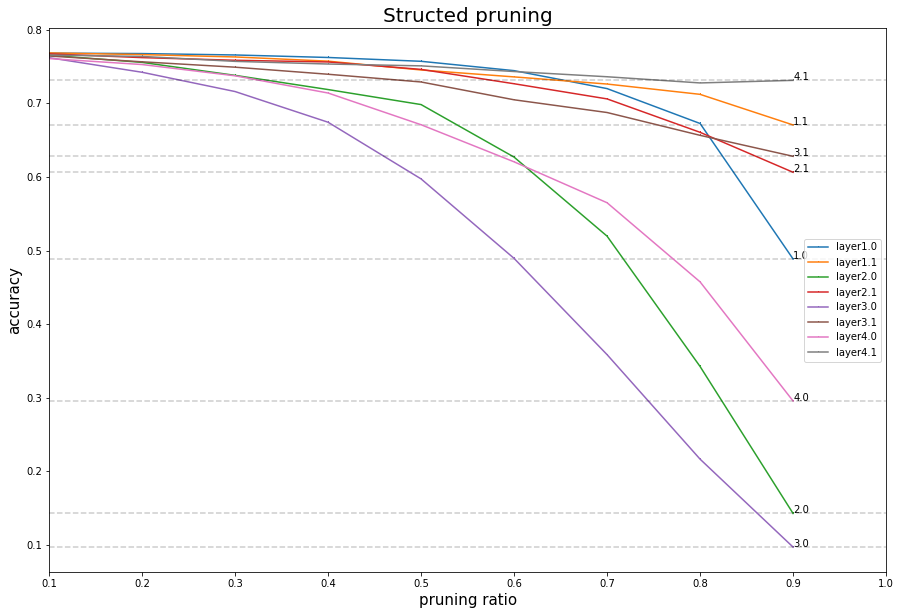

In [10]:
plt.figure(figsize=(15, 10))

for i, key in enumerate(dict_unstructed.keys()):
    accs = dict_structed[key][0]
    ratios = dict_structed[key][1]
    plt.plot(ratios, accs, ',-', label=key)
    plt.text(ratios[-1], accs[-1], key[-3:])
    plt.axhline(accs[-1], linestyle='--', c='k', alpha=0.2)

plt.xlim(ratios[0], ratios[-1]+0.1)
plt.xlabel('pruning ratio', fontsize=15)
plt.ylabel('accuracy', fontsize=15)
plt.title('Structed pruning', fontsize=20)
plt.legend()

plt.show()

## Task 5. Discussion on Accuracy-Pruning rate Trade-off for Local Structed and Unstructed Pruning [3 points]

Compare accuracy-pruning rate trade-off for different Basic blocks.

a) What can you observe and conclude when compare models with compressed blocks obtained using unstructed and structed pruning?

b) What can you obeserve and conclude when compare models with compressed blocks, when corresponding blocks belong to one ResNet layer? (e.g., layer1.0 and layer1.1)

c) What can you observe and conclude when compare models with compressed blocks from different ResNet layers? (e.g., layer1.1 and layer4.1)



**a)**

**Answer:**
Structed-pruned layers are more sensitive to pruning ratios.

**b)**

**Answer:**
It looks like from the plot above, that 3.2 point from my unstucted pruning analysis is also fair for structed.

**c)**

**Answer:**
It may be, that #.1 blocks in first and last layers both less sensitive to those ratios comparing with the rest of ResNet layers.

In [11]:
colors = "rbgk"
lines = ["-", "--"]

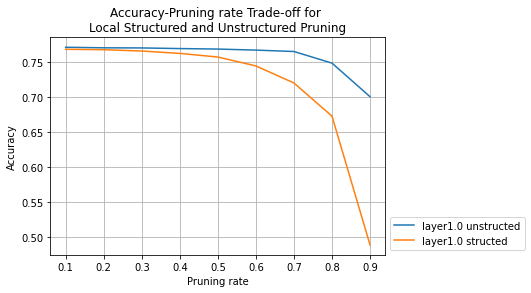

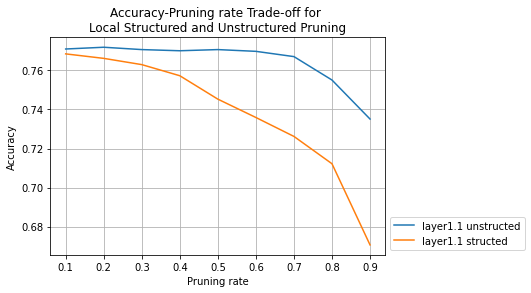

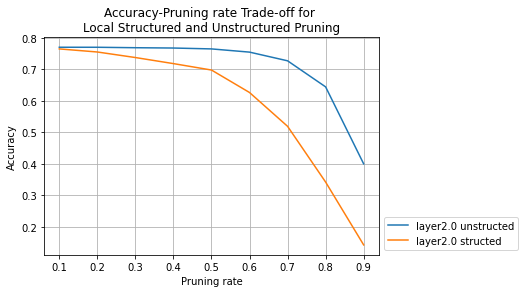

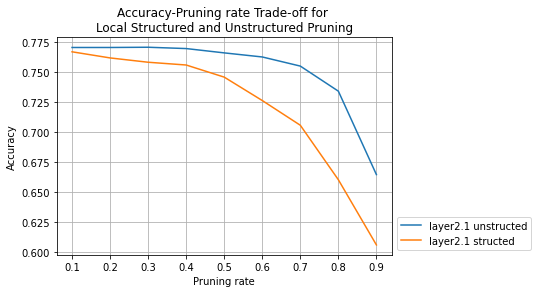

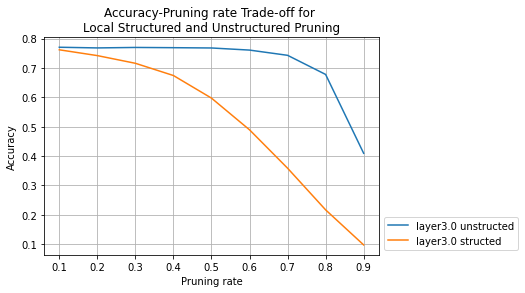

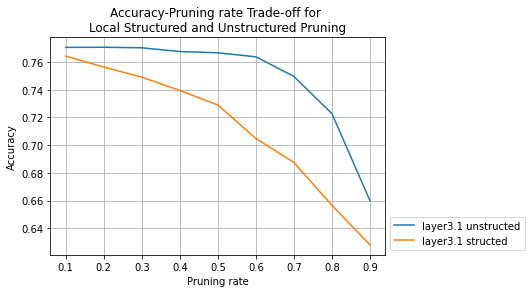

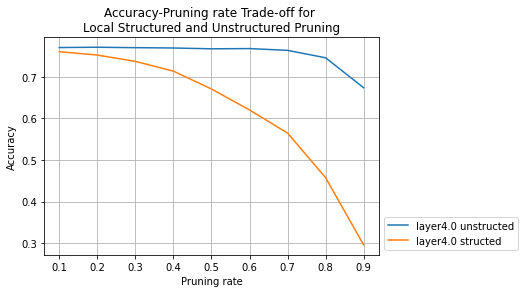

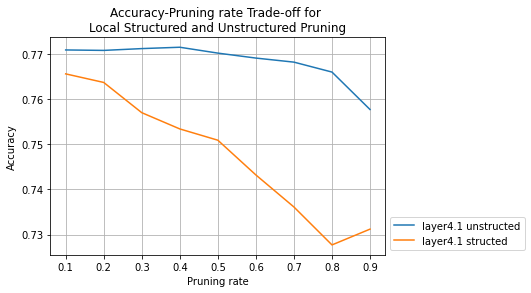

In [12]:
# helper visualization to compare results of structed and unstructed pruning

for bname in dict_structed.keys():
    accs_unstructed, _ = dict_unstructed[bname]
    accs_structed, prune_rate = dict_structed[bname]
    
    plt.plot(accs_unstructed, label=f"{bname} unstructed")
    plt.plot(accs_structed, label=f"{bname} structed")
    plt.xlabel('Pruning rate')
    plt.xticks(np.arange(len(prune_rate)), np.round(prune_rate, 2))
    plt.ylabel('Accuracy')
    plt.title(f"Accuracy-Pruning rate Trade-off for \nLocal Structured and Unstructured Pruning")


    plt.legend(loc='lower left', bbox_to_anchor=(1., 0., 0., 0.))
    plt.grid(True)
    plt.show()

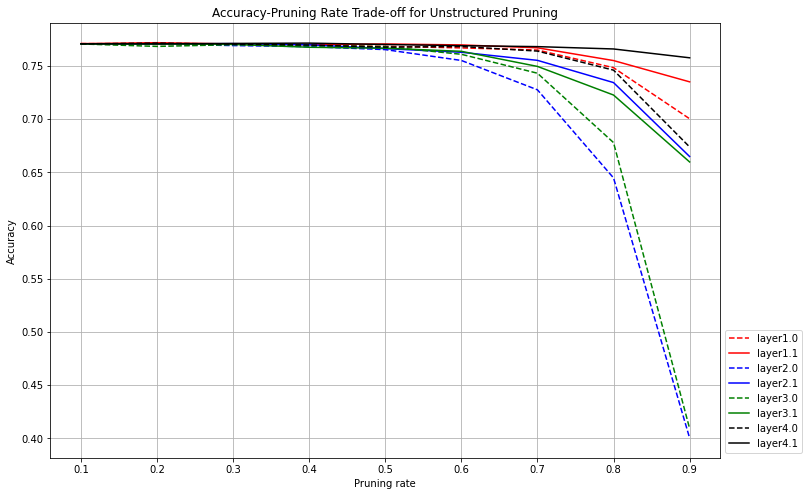

In [13]:
# helper visualization to analyze model sensitivity to the pruning of different basic blocks

plt.figure(figsize=(12, 8))

for bname, (accs, prune_ratios) in dict_unstructed.items():
    plt.plot(accs, lines[int(bname[-1])-1], color=colors[int(bname[5])-1], label=bname)
    plt.xlabel('Pruning rate')
    plt.xticks(np.arange(len(prune_ratios)), np.round(prune_ratios, 2))
    plt.ylabel('Accuracy')
    plt.title('Accuracy-Pruning Rate Trade-off for Unstructured Pruning')

plt.legend(loc='lower left', bbox_to_anchor=(1., 0., 0., 0.))
plt.grid(True)

## Task 6. Influence of BatchNorm Calibration [2 point]

Perform the same computations as in Task 3, but adding calibration of BatchNorm statistics before accuracy computation.   

That is for each Basic block for pruning rate from the list of considered pruning rates:

    - Given pruning rate prune considered Basic block (You'll get a model, where one Basic block is compressed)
    - Calibrate statistics in Batch Norm layers
    - Compute accuracies for compressed model


Note: model calibration running time is approximately 4 times large than running time of model validation. Therefore, you can compare calibrated accuracies only for several layers (please find helper visualization code below).

In [14]:
# # compute accuracies for pruned models and save them at `dict_unstructed_calibrated`.
# # don't forget to change the name of the file with saved accuraces (i.e. rename`results.npy`)

In [20]:
dict_unstructed_calibrated = {}

try:
    dict_unstructed_calibrated = np.load("cal_results.npy").item()
except:
    pass

for bname in evaluated_basicblocks:

    if bname in dict_unstructed_calibrated:
        print(f'Accuracies for BasicBlock {bname} have been already computed')
        continue
        
    print(f'\n\nStart computation for BasicBlock {bname}...')
    accs, prune_ratios = [], []
    for prune_rate in prune_rates:
        
        conv_list_local = [f'{bname}.conv1', f'{bname}.conv2']
        model_pruned = putils.prune_unstructed(model, conv_list_local, prune_rate=prune_rate)
        nonzero_ratio, _ = putils.compute_nonzero_ratio(model_pruned, conv_list_local)
        model_pruned = model_pruned.to(device)
        
        t0 = time()
        # your code for Task 6 starts here 
        # Calibrate BatchNorms

        batchnorm_callibration(model_pruned.eval(), train_loader, layer_name=conv_list_local[0], n_callibration_batches=200, device=device)
        batchnorm_callibration(model_pruned.eval(), train_loader, layer_name=conv_list_local[1], n_callibration_batches=200, device=device)

        # your code for Task 6 ends here 
        print(f'\tCalibration has taken {time() - t0: .3f}s')

        top1_acc, _ = get_validation_scores(model_pruned, val_loader, device=device)
        print(f'\tAccuracies for pruning rate {prune_rate} have been computed')
        accs += [top1_acc]
        prune_ratios += [1 - nonzero_ratio] 

    dict_unstructed_calibrated[bname] = [np.array(accs), np.array(prune_ratios)]
    np.save("cal_results.npy", dict_unstructed)



Start computation for BasicBlock layer1.0...
	Calibration has taken  34.123s


  0%|          | 0/40 [00:00<?, ?it/s]

	Accuracies for pruning rate 0.1 have been computed
	Calibration has taken  34.218s


  0%|          | 0/40 [00:00<?, ?it/s]

	Accuracies for pruning rate 0.2 have been computed
	Calibration has taken  34.899s


  0%|          | 0/40 [00:00<?, ?it/s]

	Accuracies for pruning rate 0.3 have been computed
	Calibration has taken  34.979s


  0%|          | 0/40 [00:00<?, ?it/s]

	Accuracies for pruning rate 0.4 have been computed
	Calibration has taken  35.264s


  0%|          | 0/40 [00:00<?, ?it/s]

	Accuracies for pruning rate 0.5 have been computed
	Calibration has taken  35.310s


  0%|          | 0/40 [00:00<?, ?it/s]

	Accuracies for pruning rate 0.6 have been computed
	Calibration has taken  34.882s


  0%|          | 0/40 [00:00<?, ?it/s]

	Accuracies for pruning rate 0.7 have been computed
	Calibration has taken  34.870s


  0%|          | 0/40 [00:00<?, ?it/s]

	Accuracies for pruning rate 0.8 have been computed
	Calibration has taken  34.743s


  0%|          | 0/40 [00:00<?, ?it/s]

	Accuracies for pruning rate 0.9 have been computed


Start computation for BasicBlock layer1.1...
	Calibration has taken  34.606s


  0%|          | 0/40 [00:00<?, ?it/s]

	Accuracies for pruning rate 0.1 have been computed
	Calibration has taken  34.632s


  0%|          | 0/40 [00:00<?, ?it/s]

	Accuracies for pruning rate 0.2 have been computed
	Calibration has taken  34.607s


  0%|          | 0/40 [00:00<?, ?it/s]

	Accuracies for pruning rate 0.3 have been computed
	Calibration has taken  34.637s


  0%|          | 0/40 [00:00<?, ?it/s]

	Accuracies for pruning rate 0.4 have been computed
	Calibration has taken  34.598s


  0%|          | 0/40 [00:00<?, ?it/s]

	Accuracies for pruning rate 0.5 have been computed
	Calibration has taken  34.469s


  0%|          | 0/40 [00:00<?, ?it/s]

	Accuracies for pruning rate 0.6 have been computed
	Calibration has taken  34.487s


  0%|          | 0/40 [00:00<?, ?it/s]

	Accuracies for pruning rate 0.7 have been computed
	Calibration has taken  34.439s


  0%|          | 0/40 [00:00<?, ?it/s]

	Accuracies for pruning rate 0.8 have been computed
	Calibration has taken  34.382s


  0%|          | 0/40 [00:00<?, ?it/s]

	Accuracies for pruning rate 0.9 have been computed


Start computation for BasicBlock layer2.0...
	Calibration has taken  34.496s


  0%|          | 0/40 [00:00<?, ?it/s]

	Accuracies for pruning rate 0.1 have been computed
	Calibration has taken  34.334s


  0%|          | 0/40 [00:00<?, ?it/s]

	Accuracies for pruning rate 0.2 have been computed
	Calibration has taken  34.647s


  0%|          | 0/40 [00:00<?, ?it/s]

	Accuracies for pruning rate 0.3 have been computed
	Calibration has taken  34.479s


  0%|          | 0/40 [00:00<?, ?it/s]

	Accuracies for pruning rate 0.4 have been computed
	Calibration has taken  34.598s


  0%|          | 0/40 [00:00<?, ?it/s]

	Accuracies for pruning rate 0.5 have been computed
	Calibration has taken  34.485s


  0%|          | 0/40 [00:00<?, ?it/s]

	Accuracies for pruning rate 0.6 have been computed
	Calibration has taken  34.620s


  0%|          | 0/40 [00:00<?, ?it/s]

	Accuracies for pruning rate 0.7 have been computed
	Calibration has taken  34.552s


  0%|          | 0/40 [00:00<?, ?it/s]

	Accuracies for pruning rate 0.8 have been computed
	Calibration has taken  34.477s


  0%|          | 0/40 [00:00<?, ?it/s]

	Accuracies for pruning rate 0.9 have been computed


Start computation for BasicBlock layer2.1...
	Calibration has taken  34.469s


  0%|          | 0/40 [00:00<?, ?it/s]

	Accuracies for pruning rate 0.1 have been computed
	Calibration has taken  34.580s


  0%|          | 0/40 [00:00<?, ?it/s]

	Accuracies for pruning rate 0.2 have been computed
	Calibration has taken  35.333s


  0%|          | 0/40 [00:00<?, ?it/s]

	Accuracies for pruning rate 0.3 have been computed
	Calibration has taken  34.615s


  0%|          | 0/40 [00:00<?, ?it/s]

	Accuracies for pruning rate 0.4 have been computed
	Calibration has taken  34.422s


  0%|          | 0/40 [00:00<?, ?it/s]

	Accuracies for pruning rate 0.5 have been computed
	Calibration has taken  34.515s


  0%|          | 0/40 [00:00<?, ?it/s]

	Accuracies for pruning rate 0.6 have been computed
	Calibration has taken  34.343s


  0%|          | 0/40 [00:00<?, ?it/s]

	Accuracies for pruning rate 0.7 have been computed
	Calibration has taken  34.152s


  0%|          | 0/40 [00:00<?, ?it/s]

	Accuracies for pruning rate 0.8 have been computed
	Calibration has taken  34.252s


  0%|          | 0/40 [00:00<?, ?it/s]

	Accuracies for pruning rate 0.9 have been computed


Start computation for BasicBlock layer3.0...
	Calibration has taken  34.281s


  0%|          | 0/40 [00:00<?, ?it/s]

	Accuracies for pruning rate 0.1 have been computed
	Calibration has taken  34.240s


  0%|          | 0/40 [00:00<?, ?it/s]

	Accuracies for pruning rate 0.2 have been computed
	Calibration has taken  34.313s


  0%|          | 0/40 [00:00<?, ?it/s]

	Accuracies for pruning rate 0.3 have been computed
	Calibration has taken  34.230s


  0%|          | 0/40 [00:00<?, ?it/s]

	Accuracies for pruning rate 0.4 have been computed
	Calibration has taken  34.308s


  0%|          | 0/40 [00:00<?, ?it/s]

	Accuracies for pruning rate 0.5 have been computed
	Calibration has taken  34.268s


  0%|          | 0/40 [00:00<?, ?it/s]

	Accuracies for pruning rate 0.6 have been computed
	Calibration has taken  34.229s


  0%|          | 0/40 [00:00<?, ?it/s]

	Accuracies for pruning rate 0.7 have been computed
	Calibration has taken  34.134s


  0%|          | 0/40 [00:00<?, ?it/s]

	Accuracies for pruning rate 0.8 have been computed
	Calibration has taken  34.269s


  0%|          | 0/40 [00:00<?, ?it/s]

	Accuracies for pruning rate 0.9 have been computed


Start computation for BasicBlock layer3.1...
	Calibration has taken  34.151s


  0%|          | 0/40 [00:00<?, ?it/s]

	Accuracies for pruning rate 0.1 have been computed
	Calibration has taken  34.261s


  0%|          | 0/40 [00:00<?, ?it/s]

	Accuracies for pruning rate 0.2 have been computed
	Calibration has taken  34.276s


  0%|          | 0/40 [00:00<?, ?it/s]

	Accuracies for pruning rate 0.3 have been computed
	Calibration has taken  34.280s


  0%|          | 0/40 [00:00<?, ?it/s]

	Accuracies for pruning rate 0.4 have been computed
	Calibration has taken  34.426s


  0%|          | 0/40 [00:00<?, ?it/s]

	Accuracies for pruning rate 0.5 have been computed
	Calibration has taken  34.396s


  0%|          | 0/40 [00:00<?, ?it/s]

	Accuracies for pruning rate 0.6 have been computed
	Calibration has taken  34.314s


  0%|          | 0/40 [00:00<?, ?it/s]

	Accuracies for pruning rate 0.7 have been computed
	Calibration has taken  34.501s


  0%|          | 0/40 [00:00<?, ?it/s]

	Accuracies for pruning rate 0.8 have been computed
	Calibration has taken  34.397s


  0%|          | 0/40 [00:00<?, ?it/s]

	Accuracies for pruning rate 0.9 have been computed


Start computation for BasicBlock layer4.0...
	Calibration has taken  34.352s


  0%|          | 0/40 [00:00<?, ?it/s]

	Accuracies for pruning rate 0.1 have been computed
	Calibration has taken  34.535s


  0%|          | 0/40 [00:00<?, ?it/s]

	Accuracies for pruning rate 0.2 have been computed
	Calibration has taken  34.373s


  0%|          | 0/40 [00:00<?, ?it/s]

	Accuracies for pruning rate 0.3 have been computed
	Calibration has taken  34.625s


  0%|          | 0/40 [00:00<?, ?it/s]

	Accuracies for pruning rate 0.4 have been computed
	Calibration has taken  34.346s


  0%|          | 0/40 [00:00<?, ?it/s]

	Accuracies for pruning rate 0.5 have been computed
	Calibration has taken  34.368s


  0%|          | 0/40 [00:00<?, ?it/s]

	Accuracies for pruning rate 0.6 have been computed
	Calibration has taken  34.388s


  0%|          | 0/40 [00:00<?, ?it/s]

	Accuracies for pruning rate 0.7 have been computed
	Calibration has taken  34.433s


  0%|          | 0/40 [00:00<?, ?it/s]

	Accuracies for pruning rate 0.8 have been computed
	Calibration has taken  34.193s


  0%|          | 0/40 [00:00<?, ?it/s]

	Accuracies for pruning rate 0.9 have been computed


Start computation for BasicBlock layer4.1...
	Calibration has taken  34.504s


  0%|          | 0/40 [00:00<?, ?it/s]

	Accuracies for pruning rate 0.1 have been computed
	Calibration has taken  34.512s


  0%|          | 0/40 [00:00<?, ?it/s]

	Accuracies for pruning rate 0.2 have been computed
	Calibration has taken  34.449s


  0%|          | 0/40 [00:00<?, ?it/s]

	Accuracies for pruning rate 0.3 have been computed
	Calibration has taken  34.565s


  0%|          | 0/40 [00:00<?, ?it/s]

	Accuracies for pruning rate 0.4 have been computed
	Calibration has taken  34.422s


  0%|          | 0/40 [00:00<?, ?it/s]

	Accuracies for pruning rate 0.5 have been computed
	Calibration has taken  34.425s


  0%|          | 0/40 [00:00<?, ?it/s]

	Accuracies for pruning rate 0.6 have been computed
	Calibration has taken  34.427s


  0%|          | 0/40 [00:00<?, ?it/s]

	Accuracies for pruning rate 0.7 have been computed
	Calibration has taken  34.449s


  0%|          | 0/40 [00:00<?, ?it/s]

	Accuracies for pruning rate 0.8 have been computed
	Calibration has taken  34.362s


  0%|          | 0/40 [00:00<?, ?it/s]

	Accuracies for pruning rate 0.9 have been computed


Compare accuracies computed for calibrated and not calibrated models.

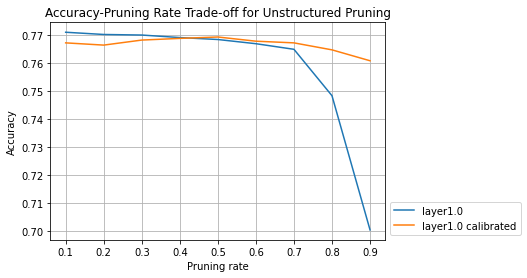

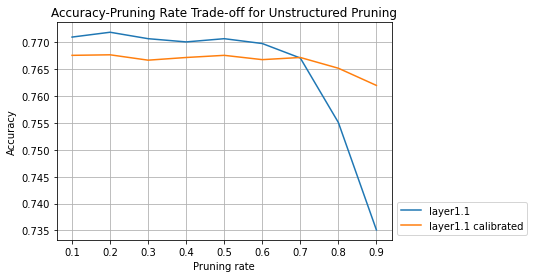

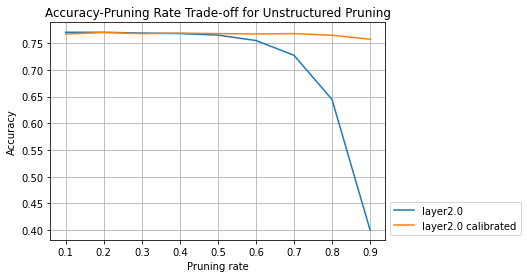

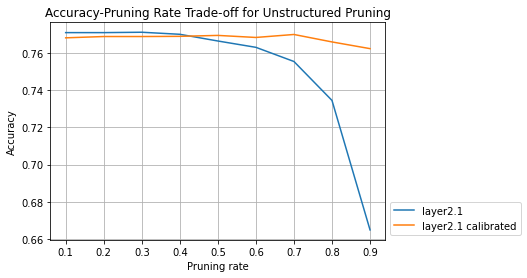

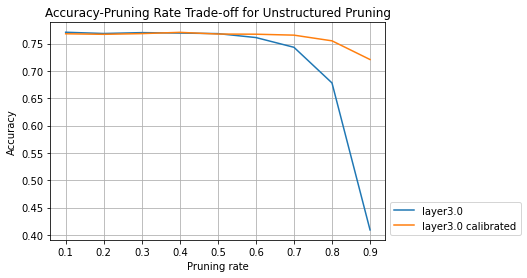

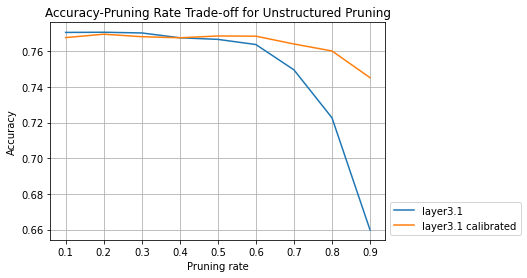

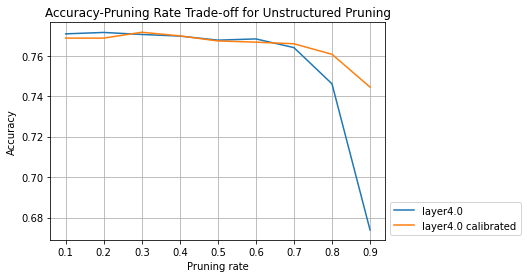

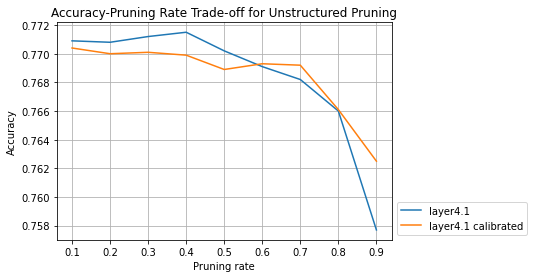

In [21]:
for bname in dict_unstructed_calibrated.keys():
    accs_uncalibrated, ratios = dict_unstructed[bname]
    accs_calibrated, _ = dict_unstructed_calibrated[bname]
    
    plt.plot(accs_uncalibrated, label=f"{bname}")
    plt.plot(accs_calibrated, label=f"{bname} calibrated")
    plt.xlabel('Pruning rate')
    plt.xticks(np.arange(len(ratios)), np.round(ratios, 2))
    plt.ylabel('Accuracy')
    plt.title('Accuracy-Pruning Rate Trade-off for Unstructured Pruning')


    plt.legend(loc='lower left', bbox_to_anchor=(1., 0., 0., 0.))
    plt.grid(True)
    plt.show()

Your answer here

Plots above leave 0 doubts that calibration is must-have approach in unstructed pruning.